In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Quantum_Kernel import *
import time

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit , transpile, Aer ,IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *

from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN
import qiskit.quantum_info as qi
from scipy import optimize
from qiskit.opflow.gradients import Gradient
from typing import Union

from IPython.display import clear_output
from scipy.optimize import approx_fprime
from tqdm import tqdm

In [3]:
# Loading your IBM Quantum account(s)
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-kqc', group='internal', project='default')

In [4]:
def simple_kernel_A(x,repeat=5):
    qc = QuantumCircuit(repeat)
    for i in range(repeat) :
        qc.rx(x[0]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])
    for i in range(repeat-2) :
        qc.cx([i],[i+2])
    encode = qc
    return [encode,repeat]

In [65]:
n_samples = 200
blobs_params = dict(random_state=0, n_samples=n_samples, n_features=2)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles,make_blobs,make_moons,make_classification

np.random.seed(0)

data0_X,data0_y = make_circles(n_samples=n_samples, factor=.5, noise=.05)
data0_X = data0_X*5
data1_X,data1_y = make_moons(n_samples=n_samples, noise=0.05, random_state=0)
data2_X,data2_y = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1, 1], **blobs_params)
data3_X,data3_y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=[1, 1], **blobs_params)
data4_X,data4_y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
data4_X += rng.uniform(size=data4_X.shape)

datasets_X = [data0_X,data1_X,data2_X,data3_X,data4_X]
datasets_y = [data0_y,data1_y,data2_y,data3_y,data4_y]


In [66]:
datasets_X_S = []
for i in range(5):
    data_temp = datasets_X[i]
    data_temp_scale = np.pi*(data_temp-np.min(data_temp))/(np.max(data_temp)-np.min(data_temp))
    datasets_X_S += [np.array(data_temp_scale)]

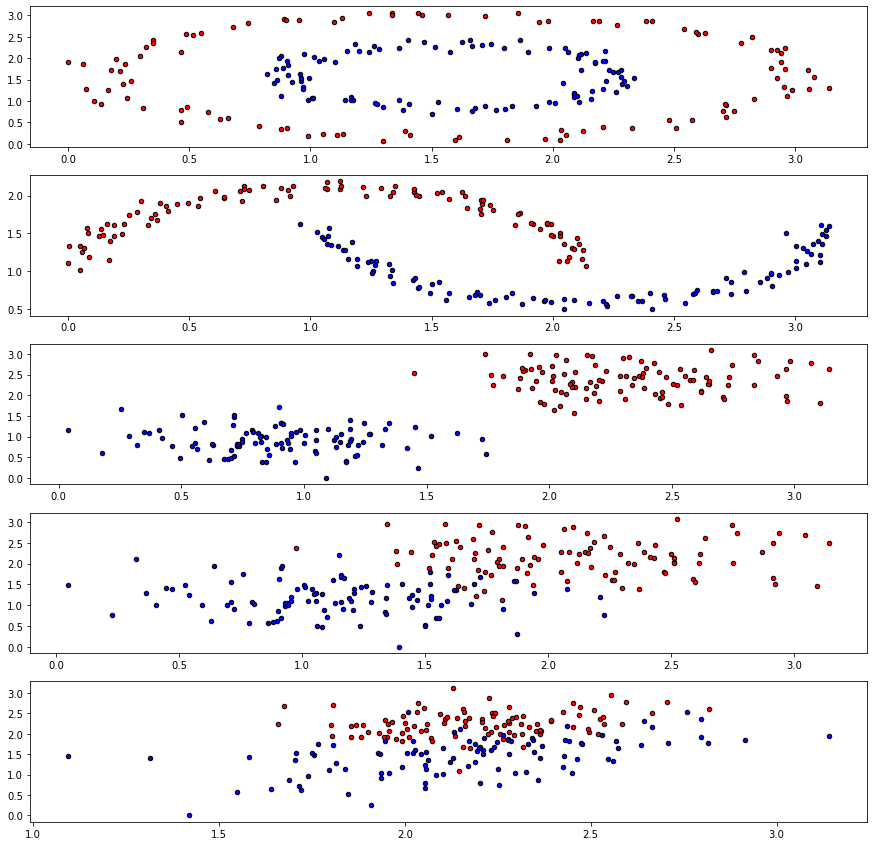

In [67]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1

    plt.subplot(5,1,i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    

In [68]:
def exponential_kernel_B(x,repeat=5):
    qc = QuantumCircuit(repeat)
    for i in range(repeat) :
        qc.rx(x[0]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])
    for i in range(repeat) :
        qc.rx(x[1]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])

    encode = qc
    return [encode,repeat]

In [69]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []
sto_index_sets = []
gram_matrix_set = []
sample = 10

for i in range(5) :
    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    sto_index_sets += [sto_ind]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,exponential_kernel_B,3,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    gram_matrix_set += [gram_matrix]

    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 77.63072633743286 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 74.40803241729736 seconds ---


 36%|███▌      | 36/100 [00:47<01:26,  1.36s/it]

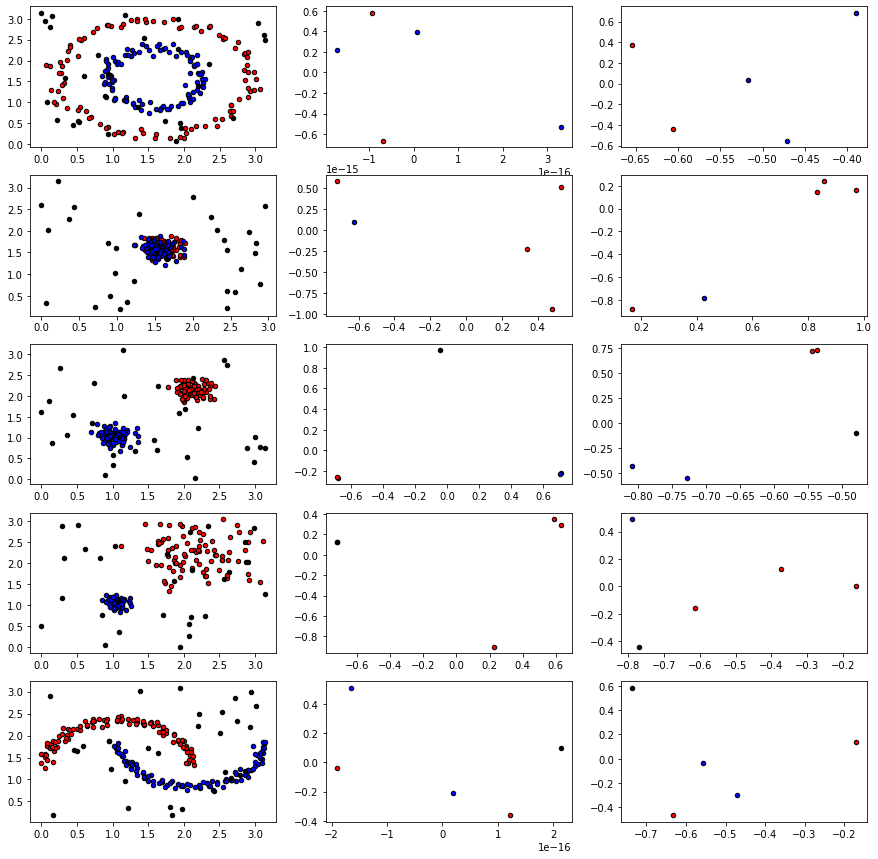

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [ ]:
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("svm_data/simulation_gaussian"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("svm_data/simulation_quantum"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_y_sto[i]).to_csv("svm_data/simulation_y_sto"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_X_S[i]).to_csv("svm_data/simulation_original"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(sto_index_sets[i]).to_csv("svm_data/sto_index"+str(i)+".csv")

In [ ]:
datasets_X = [data0_X,data1_X,data2_X,data3_X,data4_X]
datasets_y = [data0_y,data1_y,data2_y,data3_y,data4_y]


In [11]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 5

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 15.55950117111206 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 16.13760495185852 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 19.978941440582275 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 23.77816915512085 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 28.774592399597168 seconds ---


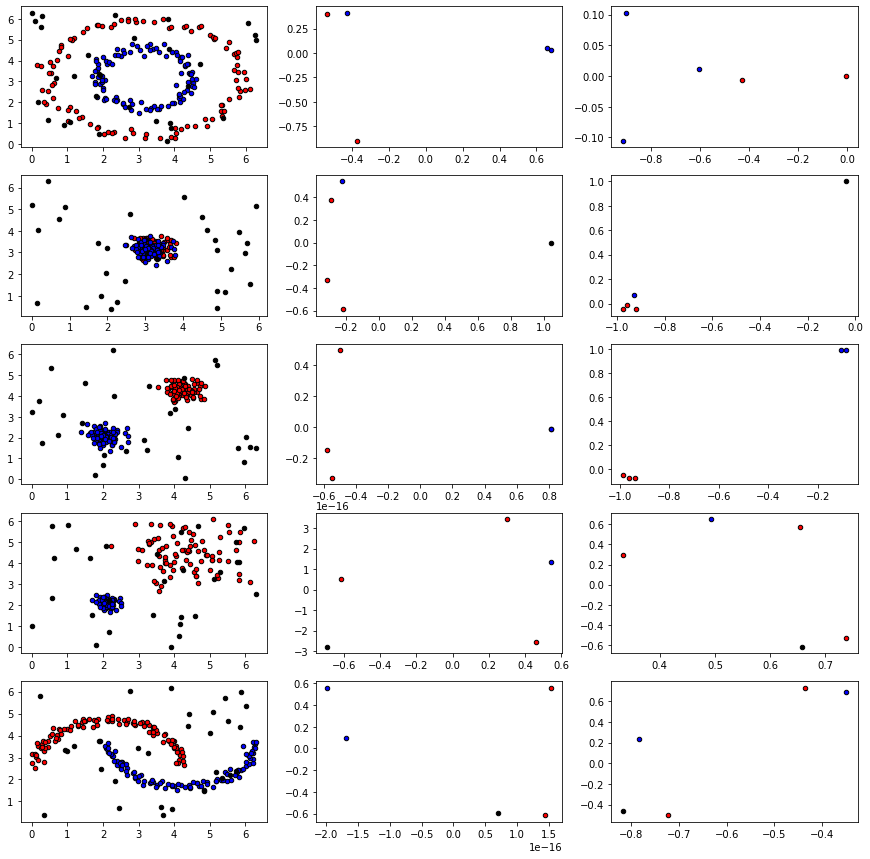

In [12]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [19]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=2,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 1105.010279417038 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1106.7268195152283 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1284.8180785179138 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1381.790937423706 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1149.532429933548 seconds ---


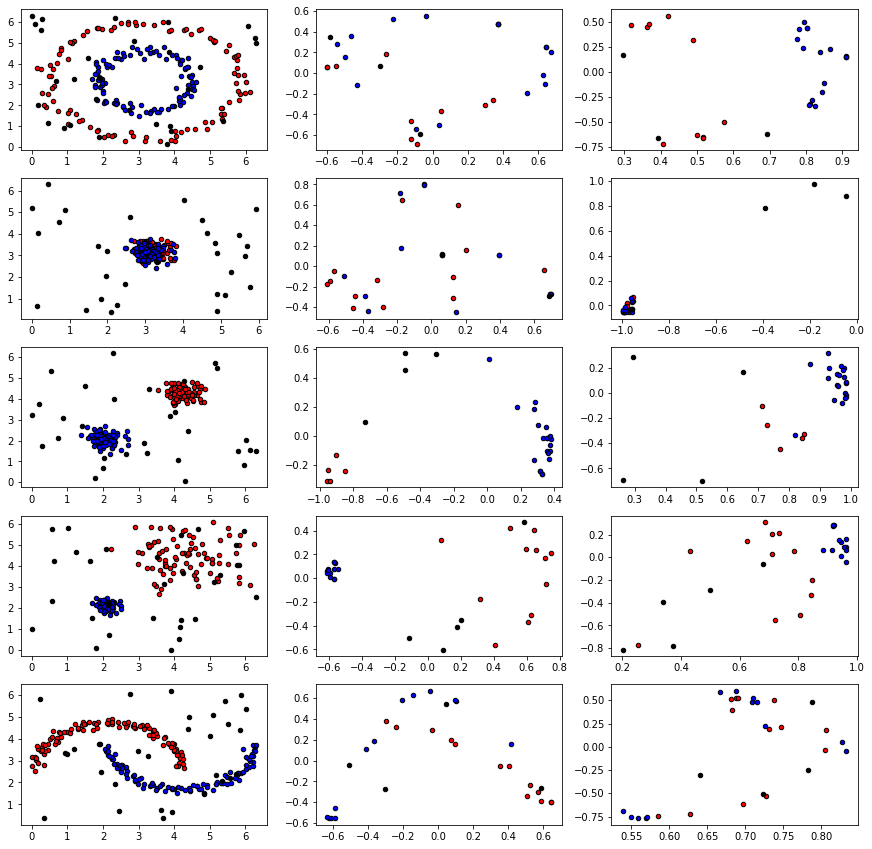

In [20]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [21]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=3,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 1599.3538699150085 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2474.6762058734894 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1653.0944194793701 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1853.5775909423828 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1578.3784518241882 seconds ---


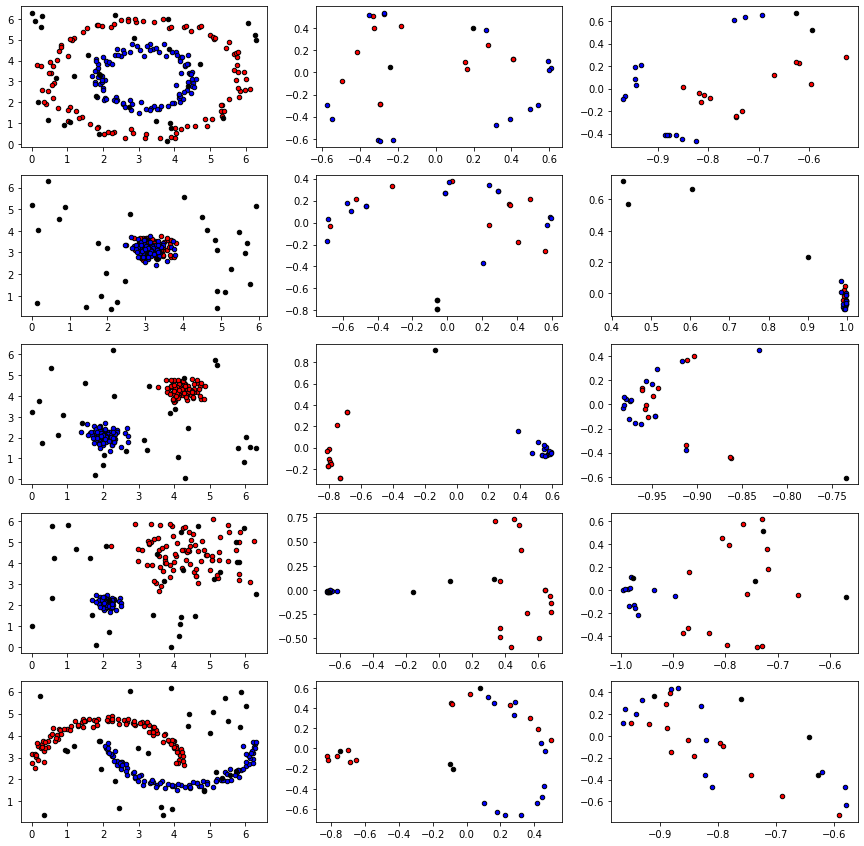

In [22]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [23]:
datasets_X_S = []
for i in range(5):
    data_temp = datasets_X[i]
    data_temp_scale = np.pi*(data_temp-np.min(data_temp))/(np.max(data_temp)-np.min(data_temp))
    datasets_X_S += [np.array(data_temp_scale)]

In [24]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=3,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 3177.7464718818665 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 3437.337141752243 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2707.8716781139374 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2128.3623456954956 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1481.6046772003174 seconds ---


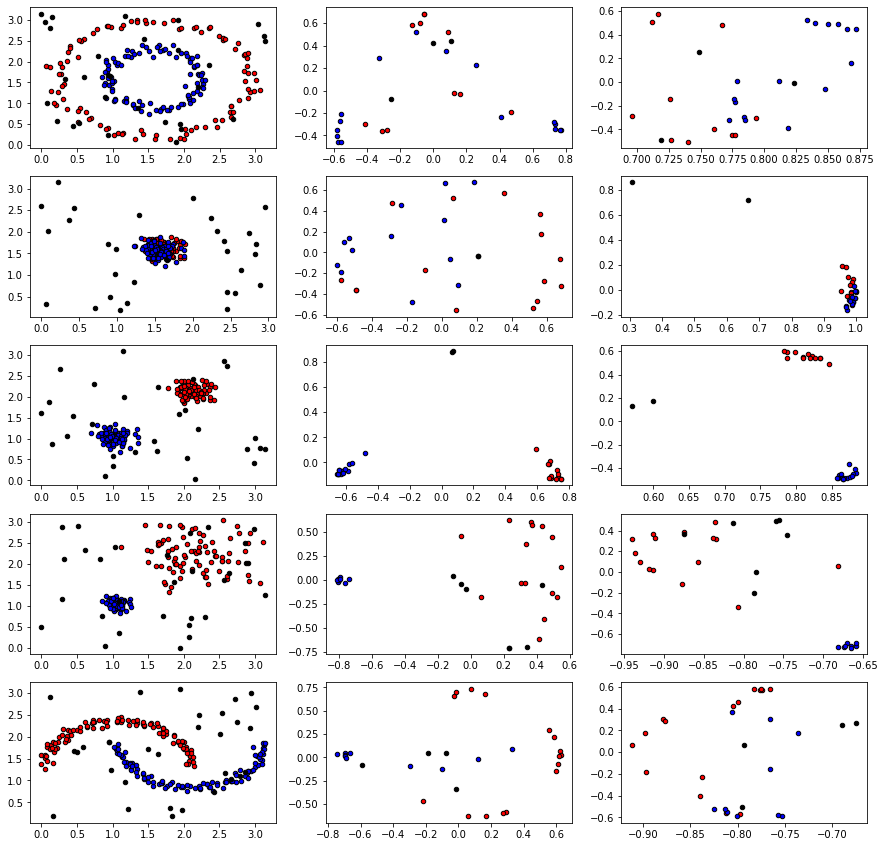

In [25]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [29]:
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("simulation_gaussian"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("simulation_quantum"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_y_sto[i]).to_csv("simulation_y_sto"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_X_S[i]).to_csv("simulation_original"+str(i)+".csv")
